Code Source: https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c

https://github.com/KhuyenLE-maths/Implementation-of-GoogLeNet-on-Keras/blob/main/Implementation_of_GoogLeNet_on_Keras.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from matplotlib import pyplot

In [ ]:
train_path="/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Train/"
val_path="/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Val/"
test_path="/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Test/"
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

In [ ]:
print(class_names)
print(class_names_val)
print(class_names_test)

['Benign', 'Malignant']
['Malignant', 'Benign']
['Benign', 'Malignant']


In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Train/",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
val_generator = val_datagen.flow_from_directory("/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Val/",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Test/",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 3644 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  # Input:
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet(nb_classes = 2):
  # input layer
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)


  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)


  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer
  X = Dropout(0.4)(X)

  # output layer
  X = Dense(units = nb_classes, activation = 'softmax')(X)

  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
model = GoogLeNet()

In [ ]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

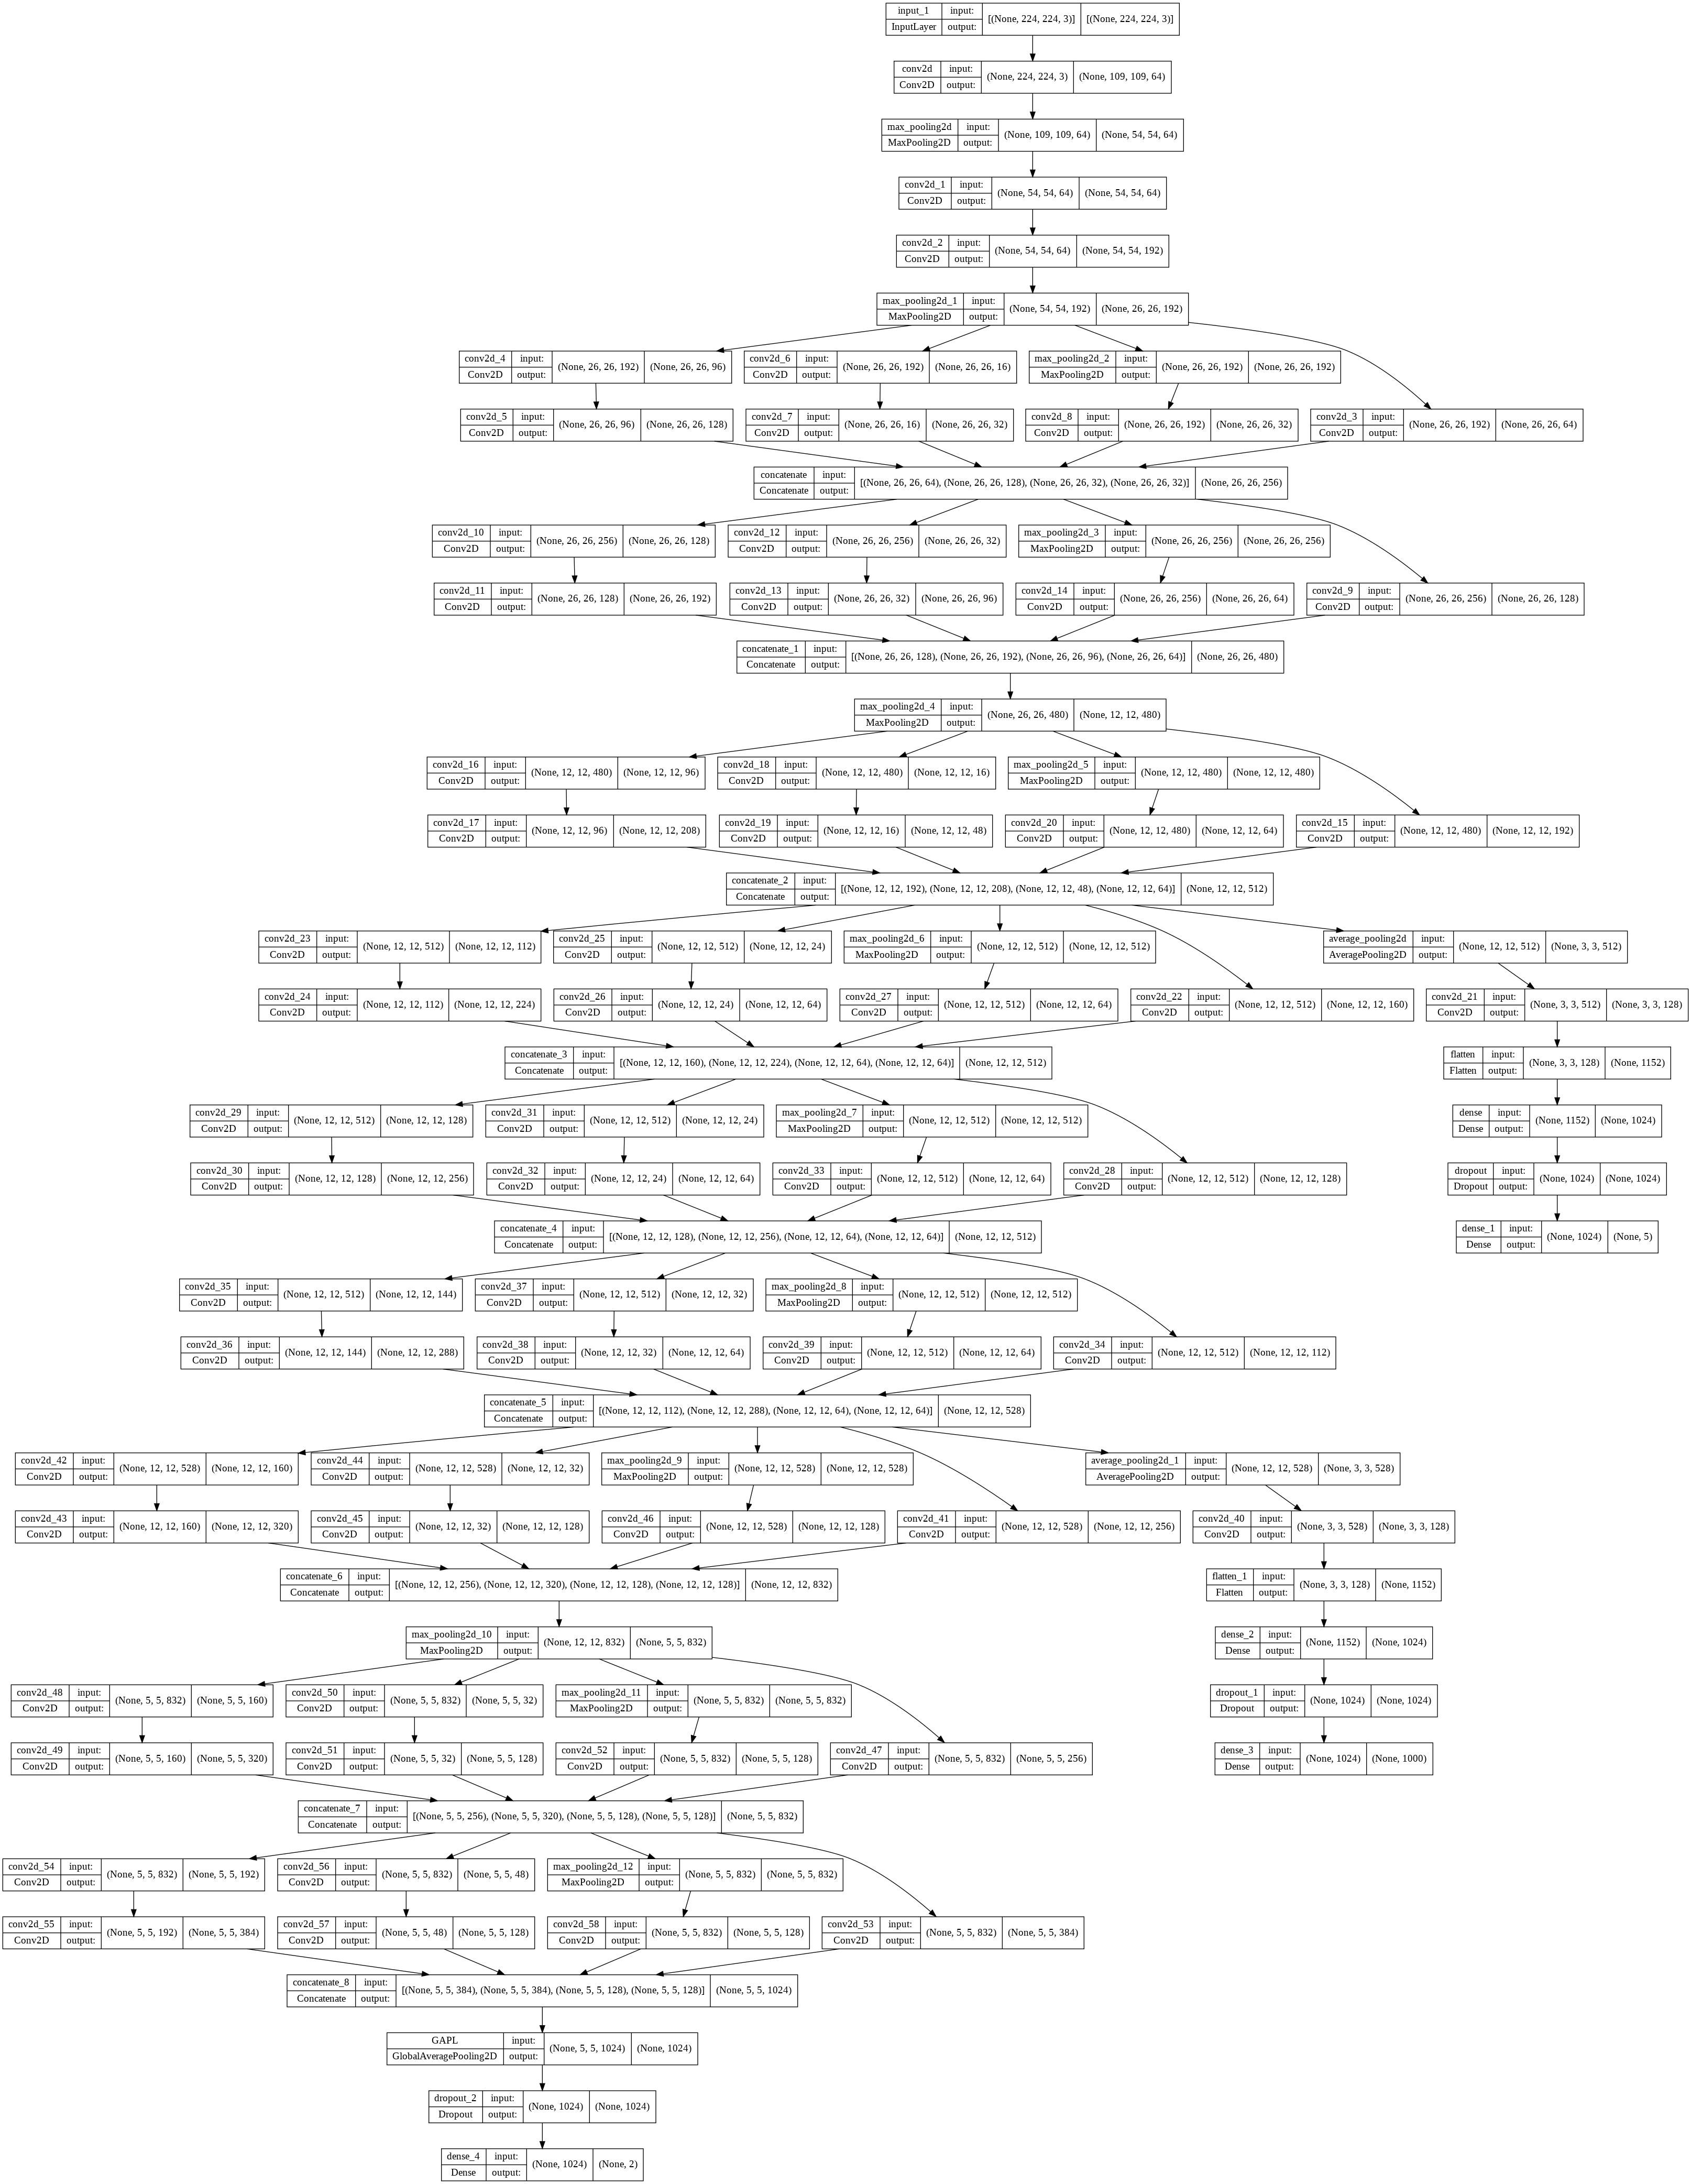

In [ ]:
dot_img_file = '/content/drive/MyDrive/Assignments/Assignment 3/GoogLeNet.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#Applying Augmentaion on data to avoid overfitting
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set =train_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Train',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Val',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Assignments/Assignment 3/Model_Training_Dataset/Test',target_size = (224, 224),batch_size = 8,class_mode = 'binary')
type(training_set)

Found 3644 images belonging to 2 classes.
Found 1561 images belonging to 2 classes.
Found 520 images belonging to 2 classes.


keras.preprocessing.image.DirectoryIterator

In [ ]:
history = model.fit(training_set,steps_per_epoch = 10,epochs = 200,validation_data = val_set,validation_steps = 5)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 17s 1s/step - loss: 5.4685 - dense_4_loss: 0.9464 - dense_1_loss: 1.0204 - dense_3_loss: 3.5017 - dense_4_accuracy: 0.7375 - dense_1_accuracy: 0.6500 - dense_3_accuracy: 0.6500 - val_loss: 2.2971 - val_dense_4_loss: 0.7481 - val_dense_1_loss: 0.6896 - val_dense_3_loss: 0.8594 - val_dense_4_accuracy: 0.6250 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6250
Epoch 2/200
10/10 [==============================] - 7s 765ms/step - loss: 2.1547 - dense_4_loss: 0.6027 - dense_1_loss: 0.6551 - dense_3_loss: 0.8969 - dense_4_accuracy: 0.7500 - dense_1_accuracy: 0.7125 - dense_3_accuracy: 0.5750 - val_loss: 2.6503 - val_dense_4_loss: 0.7256 - val_dense_1_loss: 0.8083 - val_dense_3_loss: 1.1163 - val_dense_4_accuracy: 0.6500 - val_dense_1_accuracy: 0.6500 - val_dense_3_accuracy: 0.6500
Epoch 3/200
10/10 [==============================] - 7s 757ms/step - loss: 2.0793 - dense_4_loss: 0.6161 - dense_1_loss: 0.6454 - dense_3_loss: 0.8177 - dense_4_acc

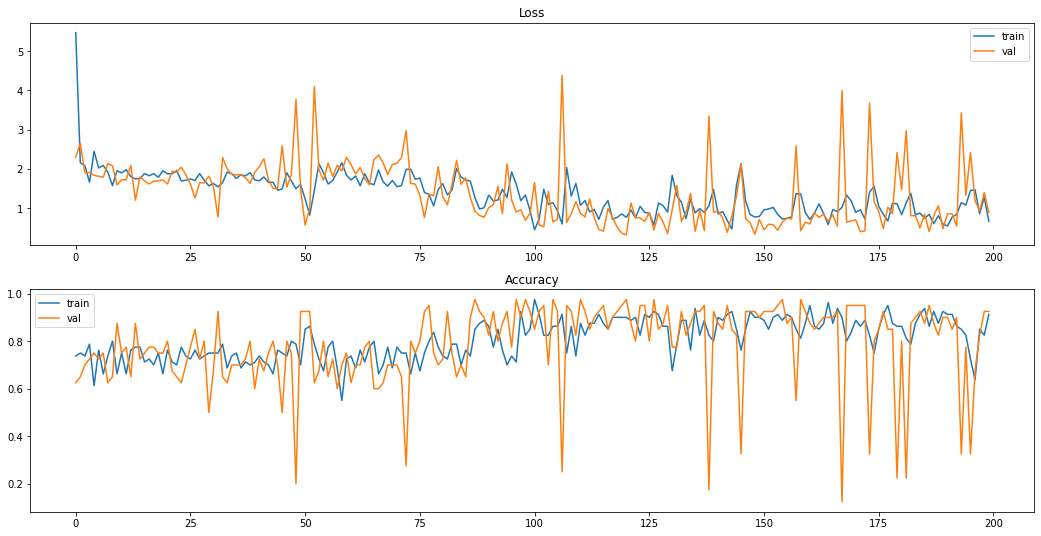

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,9)

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['dense_4_accuracy'], label='train')
pyplot.plot(history.history['val_dense_4_accuracy'], label='val')
pyplot.legend()
pyplot.savefig('/content/drive/MyDrive/Assignments/Assignment 3/TrainTest_LossAccuracy_Graph_GoogLeNet.png')
pyplot.show()

In [ ]:
#test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predicted_probalities = model.predict_generator(test_set, steps=test_set.samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Get most likely class
predicted_classes = np.argmax(predicted_probalities, axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: ignored

In [ ]:
score = model.evaluate()

In [ ]:
test_generator.class_indices

In [ ]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [ ]:
import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)

In [ ]:
confusion_matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,5)
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, annot_kws={"fontsize":18});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=18);
ax.set_ylabel('True labels', fontsize=18);
ax.set_title('Confusion Matrix',fontsize=22);
ax.xaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);
ax.yaxis.set_ticklabels(['Benign', 'Malignant'],fontsize=14);

plt.savefig('/content/drive/MyDrive/Assignments/Assignment 3/Confusion_Matrix_GoogLeNet.png')